In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_absolute_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s
from pycausal.pycausal import pycausal as pc
from collections import defaultdict
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text
from pycausal import prior as p
import itertools

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="1" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = a + np.random.normal(mean, var, SIZE)
    c =  a + b + np.random.normal(mean, var, SIZE)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c})

def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))
    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=False)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=False)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model

def get_bic(df, prior, penalty = 2):

    tetrad.run(algoId = 'fges', dfs = df, scoreId = 'cond-gauss-bic', 
           priorKnowledge = prior, dataType = 'mixed', numCategoriesToDiscretize = 4,
           structurePrior = 1.0, maxDegree = 3, faithfulnessAssumed = True, verbose = True,
              penalty = 100)
    
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)

def make_categorical(df, complete_df, categoricals):   
    retval = None
    for key in df.columns:
        if retval is not None:
            if key in categoricals:
                retval = np.concatenate((retval, to_categorical(df[key], len(complete_df[key].unique()))), axis = 1)
            else:
                retval = np.concatenate((retval, df[key].values[...,np.newaxis]), axis = 1)
        else:
            if key in categoricals:
                retval = to_categorical(df[key], len(complete_df[key].unique()))
            else:
                retval = df[key]
    return retval
num_models = 100       
pc = pc()
pc.start_vm(java_max_heap_size = '21000M')
tetrad = s.tetradrunner()

inputs = ['Sex', 'Equipment', 'Age',  'Deadlift1Kg', 'Bench1Kg']
#inputs = ['gender', 'race', 'lunch', 'test_preparation_course', 'education']#, 'math_score', 'writing_score']
target = ['Squat1Kg']
categoricals = ['Sex', 'Equipment'] 

/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
df = pd.read_csv('~/Desktop/Kaggle/openpowerlifting.csv')
df = df[['Sex', 'Equipment', 'Age', 'Squat1Kg', 'Deadlift1Kg', 'Bench1Kg']]

/home/tkyono/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)

In [4]:

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder_list = []
#one_hot = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
for i,col in enumerate(categoricals):
    label_encoder_list.append(LabelEncoder())
    df[col] = label_encoder_list[i].fit_transform(df[col].values)

In [5]:
df = df[(df['Bench1Kg'] > 0) & (df['Squat1Kg'] > 0) & (df['Deadlift1Kg'] > 0) ]
df.reset_index(drop = True, inplace = True)

In [6]:
def normalize(a):
    return (a - np.min(a)) / (np.max(a) - np.min(a))
df['Age'] = normalize(df['Age'])
df['Squat1Kg'] = normalize(df['Squat1Kg'])
df['Deadlift1Kg'] = normalize(df['Deadlift1Kg'])
df['Bench1Kg'] = normalize(df['Bench1Kg'])
#df['TotalKg'] = normalize(df['TotalKg'])

[[2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024, 512], [2048, 1024

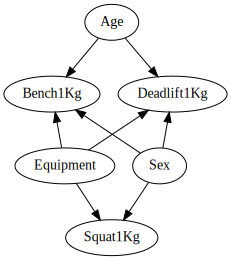

In [7]:
import pydot
from IPython.display import SVG
def examine_graph_continuous(df, prior = None):
    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               )
    return tetrad.getTetradGraph()

def examine_graph_mixed(df, prior = None):
    tetrad.run(algoId = 'fges', dfs = df, scoreId = 'cond-gauss-bic', 
           priorKnowledge = prior, dataType = 'mixed', numCategoriesToDiscretize = 5,
           structurePrior = 1.0, maxDegree = -1, faithfulnessAssumed = True, verbose = True)

    return tetrad.getTetradGraph()

def examine_graph_discrete(df, prior = None):
    tetrad.run(algoId = 'fges', dfs = df, scoreId = 'bdeu', priorKnowledge = prior, dataType = 'discrete',
               structurePrior = 1.0, samplePrior = 1.0, maxDegree = 3, faithfulnessAssumed = True, verbose = True)
    return tetrad.getTetradGraph()
    
    

tempForbid = p.ForbiddenWithin(['Sex', 'Age', 'Equipment'])
temporal = [tempForbid, p.ForbiddenWithin(['Squat1Kg',  'Deadlift1Kg', 'Bench1Kg'])]
prior = p.knowledge( addtemporal = temporal)

g = examine_graph_mixed(df[inputs + target], prior = prior)
dot_str = pc.tetradGraphToDot(g)
graphs = pydot.graph_from_dot_data(dot_str)
svg_str = graphs[0].create_svg()

known_conx = set({})
for i in tetrad.getEdges():
    if ' --> ' in i:
        known_conx.add((i.split(' --> ')[0], i.split(' --> ')[1]))
known_conx

prior = p.knowledge(addtemporal = temporal, requiredirect =  list(map(list, known_conx)),)
models = []
model_names = []



randomize = False
if randomize:
    layers = [256, 512, 1024, 2048, 4096]
    for i in range(num_models):
        network = []
        for j in range(3):
            network.append(layers[random.randint(0,len(layers) -1)])
        models.append(network)
        model_names.append('temp/random' + str(i))
    print(models, model_names)    
else:
    model_layers = [2048,1024,512]
    for i in range(num_models):
        models.append(model_layers)
        model_names.append('temp/school' + str(i))

print(models, model_names)

SVG(svg_str)



In [8]:
known_conx.add(('Age', 'Squat1Kg')), known_conx

(None,
 {('Age', 'Bench1Kg'),
  ('Age', 'Deadlift1Kg'),
  ('Age', 'Squat1Kg'),
  ('Equipment', 'Bench1Kg'),
  ('Equipment', 'Deadlift1Kg'),
  ('Equipment', 'Squat1Kg'),
  ('Sex', 'Bench1Kg'),
  ('Sex', 'Deadlift1Kg'),
  ('Sex', 'Squat1Kg')})

In [9]:
prior = p.knowledge(addtemporal = temporal, requiredirect =  list(map(list, known_conx)),)
prior

Instance of edu.cmu.tetrad.data.Knowledge2: /knowledge
addtemporal

1*  Age Equipment Sex
2*  Bench1Kg Deadlift1Kg Squat1Kg

forbiddirect

requiredirect
Equipment Bench1Kg
Age Squat1Kg
Age Bench1Kg
Equipment Squat1Kg
Age Deadlift1Kg
Sex Deadlift1Kg
Sex Bench1Kg
Equipment Deadlift1Kg
Sex Squat1Kg

In [10]:

bestMSE = []
bestBIC = []
bestCOMBO = []
original_df = df.copy()

for t in range(50):
    # let's split our df into two by race.  Let's see what happens if we 
    df = original_df[:20000].copy()
    
    holdout = 3000
        #df_test = df[df['charges'] > 0.54].copy()
    continuous = ['Age', 'Squat1Kg',  'Deadlift1Kg', 'Bench1Kg']
    #continuous = ["math_score"]
    
    '''
    end_idx = len(df) - holdout
    cont = random.randint(0, len(continuous) - 1)
    start_idx = random.randint(0, end_idx)
    print(t, "Doing range:",start_idx, start_idx + holdout, "and ", continuous[cont])
    df_test = df.nlargest(len(df) - start_idx, continuous[cont]).nsmallest(holdout, continuous[cont])
    '''

    small = random.randint(0,1)
    cont = random.randint(0, len(continuous) - 1)
    if small == 0:
        df_test = df.nsmallest(holdout, continuous[cont])
    else:
        df_test = df.nlargest(holdout, continuous[cont])
    print(t, small, continuous[cont])

    

    df.drop(df_test.index, inplace = True)
    df_test.reset_index(inplace = True)
    df.sample(frac= 1).reset_index(inplace = True) # this will shuffle and reset index

    x_test = df_test[inputs]
    y_test = df_test[target]

    causal_split = 0.2
    val_split = 0.2
    train_split = 1 - (causal_split + val_split)

    x_causal = df[inputs][-int(causal_split * len(df)) :]
    y_causal = df[target][-int(causal_split * len(df)) :]

    x_val = df[inputs][int(train_split * len(df)):-int(causal_split * len(df))]
    y_val = df[target][int(train_split * len(df)):-int(causal_split * len(df))]

    x_train = df[inputs][:int(train_split * len(df))]
    y_train = df[target][:int(train_split * len(df))]

    x_test_NN = make_categorical(x_test, original_df, categoricals)
    x_causal_NN = make_categorical(x_causal, original_df, categoricals)
    x_val_NN = make_categorical(x_val, original_df, categoricals)
    x_train_NN = make_categorical(x_train, original_df, categoricals)
    verbosity = 0

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            #clear session
            keras.backend.clear_session() 
            #get model according to specification
            model = get_model(models[idx], [0.2] * len(models), np.shape(x_train_NN)[1])
            callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                         EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
            model.compile(optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
            #print(len(X), len(y))
            model.fit(x_train_NN, y_train, epochs = 20, validation_data = (x_val_NN, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
        else:
            models[idx].fit(X,y)





    generalization = []
    metrics = []
    proposed = []
    x_causal.reset_index(drop = True, inplace = True)

    for idx, model_name in enumerate(model_names):
        #print(model_name)
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]

        y_pred = model.predict(x_test_NN)
        generalization.append(mean_absolute_error(y_pred, y_test))

        #### CHECK FOR CAUSAL METRIC HERE
        y_causal_pred = model.predict(x_causal_NN)
        causal_targets = pd.DataFrame(y_causal_pred, columns = target)
        causal_targets.reset_index(drop=True, inplace = True)
        causal_df = x_causal.join(causal_targets)



        metrics.append(mean_absolute_error(y_causal_pred, y_causal))
        #print(x_causal.head)
        bic_pred = get_bic(causal_df, prior)
        #print(bic_pred, tetrad.getEdges())

        found_conx = set({})
        for i in tetrad.getEdges():
            if ' --> ' in i:
                found_conx.add((i.split(' --> ')[0], i.split(' --> ')[1]))
        found_conx

        if found_conx == known_conx:
            proposed.append(bic_pred)
        else:
            print("******Found an error")
            print(bic_pred, tetrad.getEdges())
            # for now just remove bad model.  Will need to add it to distance metric.
            proposed.append(bic_pred)
            #metrics = metrics[:-1]
            #generalization = generalization[:-1]
    nbest = 10
    total = normalize(metrics) + normalize(proposed)
    final = pd.DataFrame(np.stack((metrics, proposed, total, generalization), axis = 1), columns = ['metrics', 'proposed', 'combined', 'generalization'])
    print("MSE = ", np.sum(final.nsmallest(nbest, 'metrics')['generalization']))
    print("BIC = ", np.sum(final.nsmallest(nbest, 'proposed')['generalization']))
    print("COMB = ",np.sum(final.nsmallest(nbest, 'combined')['generalization']))
    bestMSE.append(final.nsmallest(nbest, 'metrics')['generalization'])
    bestBIC.append(final.nsmallest(nbest, 'proposed')['generalization'])
    bestCOMBO.append(final.nsmallest(nbest, 'combined')['generalization'])
np.mean(bestMSE), np.mean(bestCOMBO), np.std(bestMSE), np.std(bestCOMBO)

0 0 Age
MSE =  0.2584557655451595
BIC =  0.2554449382208045
COMB =  0.2552616922232794
1 0 Bench1Kg
MSE =  0.40088986701141316
BIC =  0.4147722818144748
COMB =  0.4103683428617808
2 1 Age
MSE =  0.3861997032334853
BIC =  0.39355790346338226
COMB =  0.3935744538957349
3 1 Deadlift1Kg
MSE =  0.4186921922017672
BIC =  0.4117107253247036
COMB =  0.412039264724775
4 0 Bench1Kg
MSE =  0.41079414586179097
BIC =  0.4054656737017311
COMB =  0.40259218001368036
5 0 Squat1Kg
MSE =  0.5504034282335546
BIC =  0.5338545186935595
COMB =  0.54406414071712
6 1 Squat1Kg
MSE =  0.8037994002583232
BIC =  0.8014987181853874
COMB =  0.7972361387534997
7 1 Age
MSE =  0.3931854696218717
BIC =  0.39444710133581706
COMB =  0.3894217196177634
8 1 Age
MSE =  0.3887038118339694
BIC =  0.39705948177112105
COMB =  0.39379678696533577
9 1 Deadlift1Kg
MSE =  0.4236973803789791
BIC =  0.41881684895758525
COMB =  0.41992708210919927
10 1 Bench1Kg
MSE =  0.48081582645750776
BIC =  0.47657063084160206
COMB =  0.4765040293

(0.04459086449222759,
 0.04437629590060456,
 0.015160351618247728,
 0.015191464608010784)

In [11]:
def get_average_improvement(df1, df2):
    ret = []
    for i, j in zip(df1,df2):
        ret.append(np.sum(j.values - i.values))
    return ret

improvement = get_average_improvement(bestMSE, bestCOMBO)
np.mean(improvement), np.std(improvement)

(-0.0021456859162302805, 0.004325759216087972)

In [12]:
np.mean(bestMSE), np.mean(bestCOMBO), np.std(bestMSE), np.std(bestCOMBO)

(0.04459086449222759,
 0.04437629590060456,
 0.015160351618247728,
 0.015191464608010784)

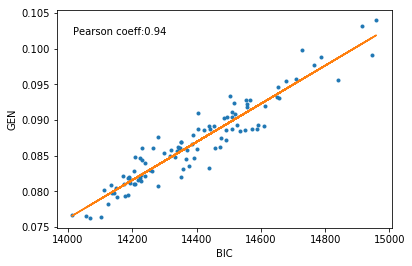

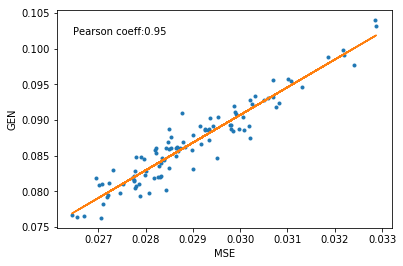

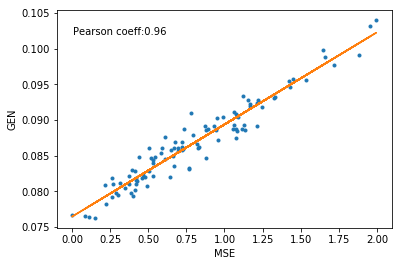

In [13]:
fig, ax = plt.subplots()
b,m = polyfit(proposed,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(proposed,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(proposed,generalization, '.')
plt.plot(proposed, b + m * np.array(proposed), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(metrics,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(metrics,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(metrics,generalization, '.')
plt.plot(metrics, b + m * np.array(metrics), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


total = normalize(metrics) + normalize(proposed)
fig, ax = plt.subplots()
b,m = polyfit(total,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(total,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(total,generalization, '.')
plt.plot(total, b + m * np.array(total), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


In [14]:
found_conx

{('Age', 'Bench1Kg'),
 ('Age', 'Deadlift1Kg'),
 ('Age', 'Squat1Kg'),
 ('Equipment', 'Bench1Kg'),
 ('Equipment', 'Deadlift1Kg'),
 ('Equipment', 'Squat1Kg'),
 ('Sex', 'Bench1Kg'),
 ('Sex', 'Deadlift1Kg'),
 ('Sex', 'Squat1Kg')}

In [15]:
nbest = 10
final = pd.DataFrame(np.stack((metrics, proposed, total, generalization), axis = 1), columns = ['metrics', 'proposed', 'combined', 'generalization'])
print("MSE = ", np.sum(final.nsmallest(nbest, 'metrics')['generalization']))
print("BIC = ", np.sum(final.nsmallest(nbest, 'proposed')['generalization']))
print("COMB = ",np.sum(final.nsmallest(nbest, 'combined')['generalization']))

MSE =  0.7865421842495053
BIC =  0.7852053566816717
COMB =  0.7868056817083808
